<a href="https://colab.research.google.com/github/business-ui/python_projects/blob/master/NYC_Rolling_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf  # now import the tensorflow module
print(tf.version)  # make sure the version is 2.x

<module 'tensorflow._api.v2.version' from 'c:\\users\\ryana\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy import stats
from scipy.stats import norm

c:\users\ryana\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
df = pd.read_csv(r"C:\Users\ryana\Downloads\nyc-rolling-sales.csv", parse_dates=True)

In [8]:
df.head(3)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00


In [9]:
df.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [10]:
del df['Unnamed: 0']
del df['APARTMENT NUMBER']

In [11]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], infer_datetime_format=True)
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['BOROUGH'] = df['BOROUGH'].astype('category')

In [12]:
df.columns = df.columns.str.replace(" ","_").str.lower()

In [13]:
print("Number of duplicated rows:",sum(df.duplicated(df.columns)))
df = df.drop_duplicates(df.columns, keep='last')
print("Duplicated rows deleted:",sum(df.duplicated(df.columns))==0)

Number of duplicated rows: 765
Duplicated rows deleted: True


In [14]:
df.dtypes

borough                                 category
neighborhood                              object
building_class_category                   object
tax_class_at_present                    category
block                                      int64
lot                                        int64
ease-ment                                 object
building_class_at_present                 object
address                                   object
zip_code                                   int64
residential_units                          int64
commercial_units                           int64
total_units                                int64
land_square_feet                         float64
gross_square_feet                        float64
year_built                                 int64
tax_class_at_time_of_sale               category
building_class_at_time_of_sale            object
sale_price                               float64
sale_date                         datetime64[ns]
dtype: object

In [15]:
miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss.columns=["name","count"]

<module 'seaborn' from 'c:\\users\\ryana\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\seaborn\\__init__.py'>

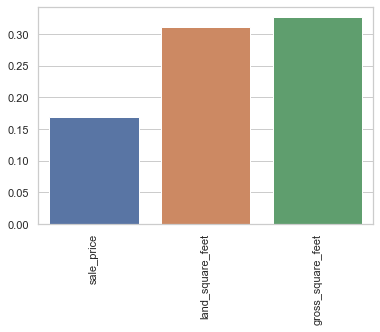

In [16]:
sns.set(style='whitegrid',color_codes=True)
sns.barplot(x=miss.index, y=miss.values)
plt.xticks(rotation=90)
sns

In [17]:
# let's fill these missing values up with mean values.
df['land_square_feet']=df['land_square_feet'].fillna(df['land_square_feet'].mean())
df['gross_square_feet']=df['gross_square_feet'].fillna(df['gross_square_feet'].mean())

In [18]:
# I want to add the weekday and month features to the dataset. January sales can differ from July sales.
df['weekday'] = df['sale_date'].apply(lambda x: datetime.datetime.weekday(x))
df['sale_day'] = pd.DatetimeIndex(df['sale_date']).day
df['sale_month'] = pd.DatetimeIndex(df['sale_date']).month
df['sale_year'] = pd.DatetimeIndex(df['sale_date']).year
del df['sale_date']

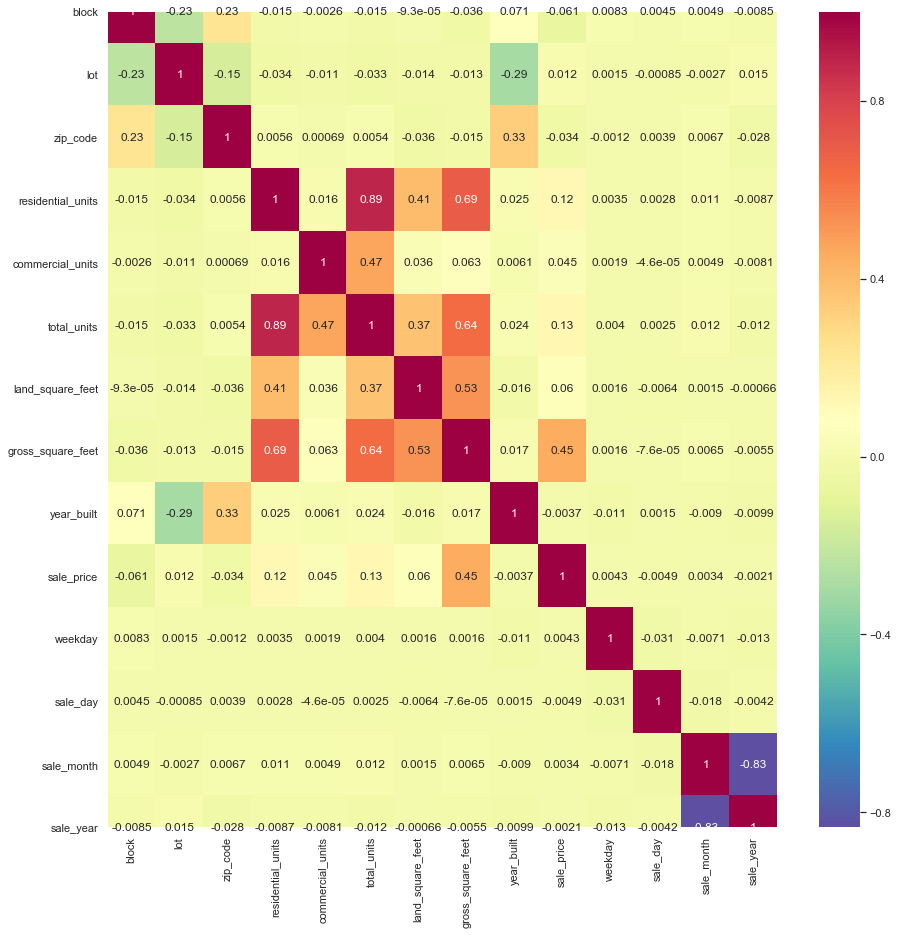

In [19]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap="Spectral_r", ax=ax)
plt.show()

In [20]:
# For a numeric representation of correlation with sale_price
df.corr()['sale_price'].sort_values(ascending=False)

sale_price           1.000000
gross_square_feet    0.449638
total_units          0.126576
residential_units    0.122465
land_square_feet     0.060132
commercial_units     0.044534
lot                  0.012319
weekday              0.004349
sale_month           0.003379
sale_year           -0.002087
year_built          -0.003708
sale_day            -0.004907
zip_code            -0.034152
block               -0.061249
Name: sale_price, dtype: float64

In [21]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,zip_code,...,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,weekday,sale_day,sale_month,sale_year
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,10009,...,1633.0,6440.0,1900,2,C2,6625000.0,2,19,7,2017
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,10009,...,4616.0,18690.0,1900,2,C7,NaN,2,14,12,2016
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,10009,...,2212.0,7803.0,1900,2,C7,NaN,4,9,12,2016
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,10009,...,2272.0,6794.0,1913,2,C4,3936272.0,4,23,9,2016
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,10009,...,2369.0,4615.0,1900,2,C2,8000000.0,3,17,11,2016


In [22]:
# separating the tax_class_at_present column into number and letter columns for comparison with tax_class_at_time_of_sale (Boolean)
df['tax_class_at_present'], df['tax_class_at_present_letter'] = df['tax_class_at_present'].str[0], df['tax_class_at_present'].str[1]
df.loc[df['tax_class_at_present_letter'].isna(),'tax_class_at_present_letter'] = 0

In [23]:
# setting blank tax_class_at_present values to the tax_class_at_time_of_sale
# same for building_class columns
# this makes an assumption, but a reasonable one, that they are the same if the present value is blank
df.loc[df['tax_class_at_present']==" ", 'tax_class_at_present'] = df.loc[df['tax_class_at_present']==" ", 'tax_class_at_time_of_sale']
df.loc[df['building_class_at_present']==" ", "building_class_at_present"] = df.loc[df['building_class_at_present']==" ", "building_class_at_time_of_sale"]

In [ ]:
for col in df[['tax_class_at_present','tax_class_at_time_of_sale','building_class_at_present','building_class_at_time_of_sale']]:
    print(col)
    df[col] = df[col].astype(str).str.strip()

tax_class_at_present
tax_class_at_time_of_sale
building_class_at_present
building_class_at_time_of_sale


In [ ]:
df.loc[(df['tax_class_at_present']!=df['tax_class_at_time_of_sale']) & (df['tax_class_at_present'].str.lower()=="nan"),
       'tax_class_at_present'] = \
       df.loc[(df['tax_class_at_present']!=df['tax_class_at_time_of_sale']) & (df['tax_class_at_present'].str.lower()=="nan"),
       'tax_class_at_time_of_sale']

df.loc[(df['building_class_at_present']!=df['building_class_at_time_of_sale']) & (df['building_class_at_present'].str.lower()=="nan"),
       'building_class_at_present'] = \
       df.loc[(df['building_class_at_present']!=df['building_class_at_time_of_sale']) & (df['building_class_at_present'].str.lower()=="nan"),
       'building_class_at_time_of_sale']

In [ ]:
df['tax_class_stays_same'] = (df['tax_class_at_present']==df['tax_class_at_time_of_sale']).astype("int")
df['building_class_stays_same'] = (df['building_class_at_present']==df['building_class_at_time_of_sale']).astype("int")

In [ ]:
# have to get close with street addresses
# an address searching algorithm would be best to normalize addresses and search for lat/long values
df['address'] = df['address'].str.split(",",n=1,expand=True)[0].str.split(" ",n=1,expand=True)[1]

In [ ]:
df.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'ease-ment',
       'building_class_at_present', 'address', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'tax_class_at_time_of_sale',
       'building_class_at_time_of_sale', 'sale_price', 'weekday', 'sale_day',
       'sale_month', 'sale_year', 'tax_class_at_present_letter',
       'tax_class_stays_same', 'building_class_stays_same'],
      dtype='object')

In [ ]:
orig_data_length = len(df)
df = df[(df['sale_price'] > 100000) & (df['sale_price'] < 5000000)]
# df = df[df['gross_square_feet'] < 10000]
# df = df[df['land_square_feet'] < 10000]
# df = df[(df['total_units'] > 0) & (df['total_units'] != 2261)]
print("Percentage of original data left:",str(round((len(df)/orig_data_length)*100,1))+"%")
print("New Dataset Shape:",df.shape)

Percentage of original data left: 65.1%
New Dataset Shape: (54579, 26)


In [ ]:
print("Skewness: %f" % df['sale_price'].skew())
print("Kurtosis: %f" % df['sale_price'].kurt())

Skewness: 2.344063
Kurtosis: 6.358450


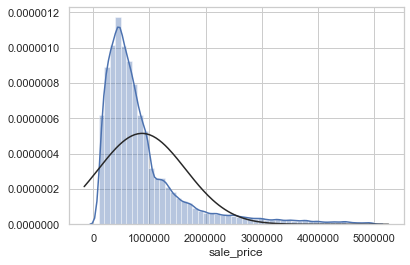

In [ ]:
sns.distplot(df['sale_price'],fit=norm)
plt.show()

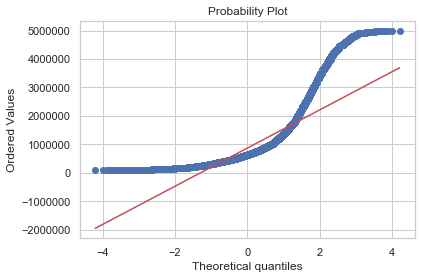

In [ ]:
stats.probplot(df['sale_price'], plot=plt)
plt.show()

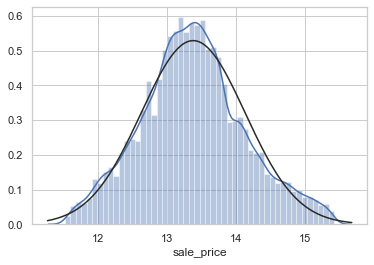

In [ ]:
sns.distplot(df['sale_price'].apply(np.log),fit=norm)
plt.show()

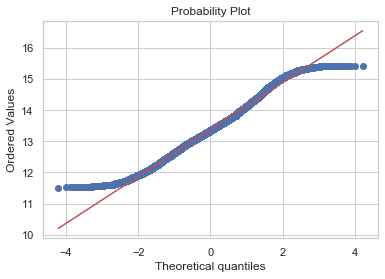

In [ ]:
stats.probplot(df['sale_price'].apply(np.log),plot=plt)
plt.show()

The following algorithm is my **LOVELY** way of searching and comparing:
*  \# of outliers when log-transformed
*  \# of outliers without transformation

The columns with less outliers when transformed are scaled and overwritten in the original dataframe.

In [ ]:
for col in df.select_dtypes(include=[np.number]).drop(['year_built','weekday','sale_month','sale_day','sale_year'], axis=1):
    outliers = np.where(
        np.abs(
            stats.zscore(
                df[col]
            )
        ) > 3 )[0]
    
    log_transformed_outliers = np.where(
        np.abs(
            stats.zscore(
                df[col].apply(
                    lambda x: np.log(x) if (x != 0) & (x != np.nan) else 1e-100
                )
            )
        ) > 3 )[0]
    
    print(df[col].name)
    print("outliers:",len(outliers))
    print("log transformed outliers:",len(log_transformed_outliers))
    print()
    if len(log_transformed_outliers) < len(outliers):
      df[col] = df[col].apply(lambda x: np.log(x) if (x != 0) & (x != np.nan) else 1e-20)

block
outliers: 650
log transformed outliers: 991

lot
outliers: 581
log transformed outliers: 0

zip_code
outliers: 494
log transformed outliers: 494

residential_units
outliers: 49
log transformed outliers: 930

commercial_units
outliers: 5
log transformed outliers: 444

total_units
outliers: 38
log transformed outliers: 920

land_square_feet
outliers: 23
log transformed outliers: 0

gross_square_feet
outliers: 44
log transformed outliers: 0

sale_price
outliers: 1566
log transformed outliers: 0

tax_class_stays_same
outliers: 13
log transformed outliers: 13

building_class_stays_same
outliers: 114
log transformed outliers: 114



0.198994620445416


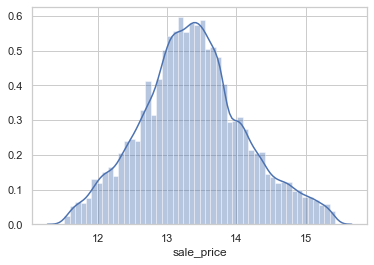

In [ ]:
sales=df['sale_price']
print(sales.skew())
sns.distplot(sales)

In [ ]:
pd.DataFrame(df.corr()['sale_price'].sort_values(ascending=False)).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>sale_price</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>sale_price</th>\n      <td>1.000000</td>\n    </tr>\n    <tr>\n      <th>lot</th>\n      <td>0.212401</td>\n    </tr>\n    <tr>\n      <th>gross_square_feet</th>\n      <td>0.131576</td>\n    </tr>\n    <tr>\n      <th>land_square_feet</th>\n      <td>0.101083</td>\n    </tr>\n    <tr>\n      <th>sale_year</th>\n      <td>0.044312</td>\n    </tr>\n    <tr>\n      <th>residential_units</th>\n      <td>0.027976</td>\n    </tr>\n    <tr>\n      <th>total_units</th>\n      <td>0.020053</td>\n    </tr>\n    <tr>\n      <th>commercial_units</th>\n      <td>0.001248</td>\n    </tr>\n    <tr>\n      <th>sale_day</th>\n      <td>-0.003934</td>\n    </tr>\n    <tr>\n      <th>building_class_stays_same</th>\n      <td>-0.006486</td>\n    </tr>\n    <tr>\n      <th>weekday</th>\n      <td>-0.010414</td>\n    </tr>\n

In [ ]:
CATEGORICAL_COLUMNS = ['borough', 
                       'weekday', 
                       'sale_day',
                       'sale_month', 
                       'sale_year', 
                       'tax_class_at_present_letter',
                       'tax_class_stays_same',
                       'building_class_stays_same',
                       'tax_class_at_time_of_sale',
                       'building_class_at_time_of_sale',
                       'year_built',
                       'neighborhood',
                       'building_class_category',
                       'tax_class_at_present',
                       'block',
                       'lot',
                       'ease-ment',
                       'building_class_at_present', 
                       'address',
                       'zip_code']
NUMERIC_COLUMNS = ['residential_units','commercial_units', 'total_units', 'land_square_feet','gross_square_feet']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  df[feature_name] = df[feature_name].astype('str')
  vocabulary = df[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  df[feature_name] = df[feature_name].astype('float64')
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))

In [ ]:
dftrain, dfeval, y_train, y_eval = train_test_split(df,df.pop('sale_price'), test_size=0.25, random_state=42)

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [ ]:
estimator = tf.estimator.BoostedTreesRegressor(n_batches_per_layer=32,feature_columns=feature_columns,learning_rate=0.05)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ryana\\AppData\\Local\\Temp\\tmpiqqecink', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
estimator.train(train_input_fn)  # train
result = estimator.evaluate(eval_input_fn)  # get model metrics/stats by evaluating testing data

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.


In [ ]:
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

In [ ]:
pred_dicts = list(estimator.predict(eval_input_fn))

preds = pd.Series([pred['predictions'][0] for pred in pred_dicts])

actuals = y_eval.reset_index(drop=True)

In [ ]:
print(actuals.head())
print(preds.head())

## Keep in mind that these are the log-transformed values of sale_price. 
## If you want to compute the errors with non-transformed values, use the following equation: 
## $$error = 10e^{actual} - 10e^{prediction}$$ 

In [ ]:
result

In [ ]:
error = actuals - preds
print(error.describe())
plt.hist(error, bins = 50,range=(-2,2))
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

## The first thing we have to check is whether the residuals are biased or not. We know from elementary statistics that the mean value of the residuals is zero, so we can start checking with a Student’s t-test if it’s true or not for our holdout sample.

In [ ]:
_, p_val = stats.ttest_1samp(error)
print("P-value of the residuals:",p_val)

## As we can see, the p-value is greater than 5%, so we cannot reject the null hypothesis and can say that the mean value of the holdout residuals is statistically similar to 0.
## Then, we can test if the holdout residuals have the same average as the training ones. This is called Welch’s t-test.

In [ ]:
fig, ax = plt.subplots(nrows= 1, ncols = 1)

ax.scatter(x = actuals.apply(np.exp), y = preds.apply(np.exp))
ax.set_aspect("equal")
ax.set_xlim(11,16)
ax.set_ylim(11,16)
z = np.polyfit(actuals.apply(np.exp), preds.apply(np.exp), 1)
p = np.poly1d(z)
ax.plot(actuals.apply(np.exp), p(actuals.apply(np.exp)),"r--")
ax.set_title("Actual vs. Predicted values")
ax.set_xlabel("Actuals")
ax.set_ylabel("Predicted")


fig.show()

In [ ]:
print('R^2 score: {}'.format(r2_score(actuals, preds)))

print("Root Mean Squared Error: {}".format(rmse(actuals, preds)))

In [ ]:
_, p_val = stats.ttest_ind(actuals, preds, equal_var=False)
print("The P-value of the two-sampled t-test:",p_val)

## Again, a p-value higher than 5% can make us tell that there aren’t enough reasons to assume that the mean values are different.

## F-test
### After we have checked the mean value, there comes the variance. We obviously want that the holdout residuals show a behavior not so much different from the training residuals, so we can compare the variances of the two sets and check whether the holdout variance is higher than the training variance.
### A good test to check if a variance is greater than another one is the F-test, but it only works with normally distributed residuals. If the distribution is not normal, the test might give wrong results.
### So, if we really want to use this test, we must check the normality of the residuals using (for example) a Shapiro-Wilk test.

In [ ]:
_, p_val = stats.shapiro(actuals)
print("The P-value of the Shapiro test for the training data is:",p_val)
_, p_val = stats.shapiro(preds)
print("The P-value of the Shapiro test for the test data is:",p_val)

In [ ]:
F = np.var(actuals) / np.var(preds)
p_value = scipy.stats.f.cdf(F, actuals, preds)
print("The P-value of the F test for difference of variances is:",p_val)

## The p-value is 72%, which is greater than 5% and allows us to say that the two sets have the same variance.